In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np
import pandas as pd
# stats tools

from scipy.interpolate import griddata
import matplotlib.pyplot as plt


# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [2]:
%matplotlib inline

## Metadata processing (BC and US West)

In [13]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    land_mask = hdf_io['land_mask'][...]

In [14]:
metadata = pd.read_fwf(OBS_dir+'metadata.txt', widths=[12, 8, 10, 7], header=None) # only read 4 columns
metadata.columns = ['stn code', 'lat', 'lon', 'elev']

In [15]:
stn_lon = metadata['lon'].values
stn_lat = metadata['lat'].values

In [16]:
indx, indy = du.grid_search(lon_4km, lat_4km, stn_lon, stn_lat)
flag_pick = ~land_mask[indx, indy]
flag_pick[indx==np.min(indx)]=False
flag_pick[indx==np.max(indx)]=False
flag_pick[indy==np.min(indy)]=False
flag_pick[indy==np.max(indy)]=False
metadata_USBC = metadata.iloc[flag_pick]

In [17]:
stn_lon_USBC = metadata_USBC['lon'].values
stn_lat_USBC = metadata_USBC['lat'].values

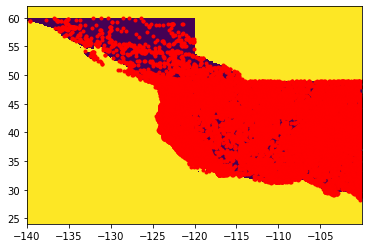

In [18]:
plt.plot(stn_lon_USBC, stn_lat_USBC, 'r.')
plt.pcolormesh(lon_4km, lat_4km, land_mask)

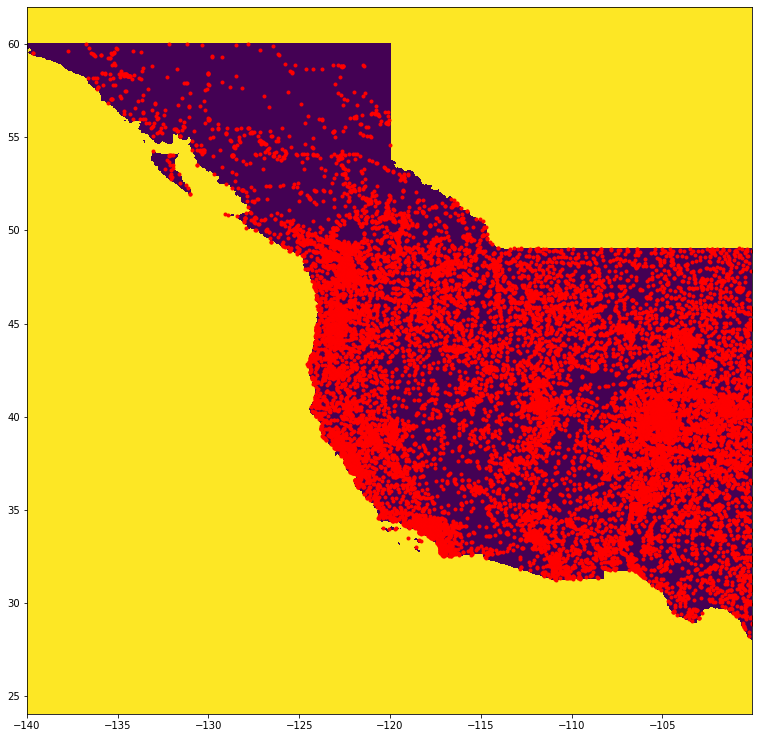

In [21]:
plt.figure(figsize=(13, 13))
plt.pcolormesh(lon_4km, lat_4km, land_mask)
plt.plot(stn_lon_USBC, stn_lat_USBC, 'r.')

In [20]:
with pd.HDFStore(OBS_dir+'metadata.hdf', 'w') as hdf_temp:
    hdf_temp['metadata'] = metadata
    hdf_temp['metadata_USBC'] = metadata_USBC

## By year csv processing

In [118]:
obs2020 = pd.read_csv(OBS_CSV_dir+'2020.csv', header=None)
obs2020.columns = ['stn code', 'date', 'variable', 'value', 'measurement flag', 'quality flag', 'source flag', 'obstime']

In [119]:
obs2020 = obs2020[obs2020['variable'].str.contains('TAVG')]

In [145]:
qc_flag = np.logical_not(obs2020['quality flag'].map(type).eq(str).values)
obs2020_qc = obs2020.iloc[qc_flag]

In [146]:
obs2020_qc = obs2020_qc.drop('variable', 1)
obs2020_qc = obs2020_qc.drop('measurement flag', 1)
obs2020_qc = obs2020_qc.drop('quality flag', 1)
obs2020_qc = obs2020_qc.drop('source flag', 1)
obs2020_qc = obs2020_qc.drop('obstime', 1)

In [223]:
stns = obs2020_qc['stn code'].values
stn_domain = metadata_USBC['stn code'].values
domain_flag = np.zeros(len(stns)).astype(bool)

for i, stn in enumerate(stns):
    if stn in stn_domain:
        domain_flag[i] = True

obs2020_BCUS = obs2020_qc.iloc[domain_flag]
dict_obs2020_BCUS = dict(tuple(obs2020_BCUS.groupby('stn code')))

In [224]:
hdf_keys = list(dict_obs2020_BCUS.keys())
with pd.HDFStore(OBS_dir+'obs2020.hdf', 'w') as hdf_temp:
    for hdf_key in hdf_keys:
        temp_pd = dict_obs2020_BCUS[hdf_key]
        # datetime conversion
        temp_pd['date'] = pd.to_datetime(temp_pd['date'], format='%Y%m%d')
        temp_pd['date'] = temp_pd['date'].dt.date.values
        #
        hdf_temp[hdf_key] = dict_obs2020_BCUS[hdf_key]

/glade/work/ksha/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['stn code', 'date'], dtype='object')]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [225]:
temp_pd

,stn code,date,value
28653,USW00094240,2020-01-01,99
120435,USW00094240,2020-01-02,48
212861,USW00094240,2020-01-03,93
304380,USW00094240,2020-01-04,71
395033,USW00094240,2020-01-05,63
...,...,...,...
7242199,USW00094240,2020-03-26,42
7311413,USW00094240,2020-03-27,65
7380389,USW00094240,2020-03-28,84
7449021,USW00094240,2020-03-29,76
